In [2]:
import json
import random
import sys
import numpy as np
import pandas as pd
import matplotlib
from tqdm import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from cartopy import crs as ccrs


def normalize_with_sign(lst):
    # 将列表转换为NumPy数组
    arr = np.array(lst)

    # 获取原始符号
    signs = np.sign(arr)

    # 取绝对值
    abs_arr = np.abs(arr)

    # 对绝对值进行log归一化处理
    log_arr = np.log1p(abs_arr)  # 使用log1p避免log(0)的情况

    # 将归一化后的值恢复到原始符号
    normalized_arr = log_arr * signs

    return normalized_arr.tolist()

date = '01-10'
city = 'Louisville'
file_name = f'KY_2022-{date}.csv'
safegraph_df = pd.read_csv(file_name)
condition = safegraph_df['city'] == 'Louisville'
poi_cbg = safegraph_df[condition]['poi_cbg'].tolist()
cbgs_list = list(set(poi_cbg))
cbgs_list = [str(x) for x in cbgs_list]

with open('Aij_KY_Louisville_01-10.json', 'r', encoding='utf-8') as f:
    Aij_dict = json.load(f)

matrix = np.array([value for value in Aij_dict.values()])
matrix[matrix > 0] = 1
print(len(matrix))

Aij_matrix = np.array(list(Aij_dict.values()))
row_sums = Aij_matrix.sum(axis=1)
column_sums = Aij_matrix.sum(axis=0)
jingliuchu = column_sums - row_sums
log_jingliuchu = normalize_with_sign(jingliuchu)

cbg = gpd.read_file("cbg.geojson")
# cbg_louisville = cbg[cbg['CensusBlockGroup'].isin(cbgs_list)]
cbg_louisville = cbg[cbg['CensusBlockGroup'].isin(cbgs_list)].set_index('CensusBlockGroup').reindex(cbgs_list).reset_index()

cbg_louisville["x"] = log_jingliuchu
cbg_louisville_wm = cbg_louisville.to_crs(epsg=3857)

df_aea_centroids = gpd.GeoDataFrame(geometry=cbg_louisville.geometry.centroid)
df_aea_centroids["x"] = jingliuchu
df_aea_centroids['color'] = np.where(df_aea_centroids['x'] > 0, "red", "blue")
df_aea_centroids_wm = df_aea_centroids.to_crs(epsg=3857)


579


/tmp/ipykernel_2380335/3291156638.py:61: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_aea_centroids = gpd.GeoDataFrame(geometry=cbg_louisville.geometry.centroid)


In [4]:
import geopandas as gpd
import folium
from branca.colormap import linear
from branca.colormap import LinearColormap

non_zero_counts = []

# 遍历每一行
for row in matrix:
    # 统计该行中非零元素的数量
    count = sum(1 for x in row if x != 0)
    non_zero_counts.append(count)

# 假设您的 GeoDataFrame 变量名为 gdf
gdf = df_aea_centroids_wm  # 请确保这是正确的 GeoDataFrame 变量名
if len(non_zero_counts) != len(gdf):
    raise ValueError("列表长度必须与 GeoDataFrame 的行数一致！")

# non_zero_counts.sort(reverse=True)
print(non_zero_counts)
# 将列表添加到 GeoDataFrame 作为新列 'connection_num'
gdf['connection_num'] = non_zero_counts

# 1. 确保 x 列中的所有数值为正数
# 根据您的描述，x 列已经是正值（包括 0 和大于 0 的值），这里仅作检查和确保
gdf['x'] = gdf['x'].abs()  # 使用 abs() 确保所有值均为正数（虽然可能不需要）

# 2. 对 x 列应用对数变换
# 使用 np.log1p 来处理 x 值，避免 log(0) 的问题（log1p(x) = log(1 + x)）
gdf['x_log'] = np.log1p(gdf['x'])  # 创建一个新列 'x_log'，存储对数变换后的值

# 1. 检查并转换坐标系到 WGS84（EPSG:4326）
# Folium 需要经纬度坐标（WGS84），而您的 geometry 列可能是投影坐标系
if gdf.crs is None:
    # 如果 CRS 未定义，假设原始坐标系为 Web Mercator (EPSG:3857)
    gdf.set_crs('EPSG:3857', inplace=True)
if gdf.crs != 'EPSG:4326':
    gdf = gdf.to_crs('EPSG:4326')

# 2. 从 geometry 列提取经纬度
gdf['longitude'] = gdf['geometry'].x  # 提取经度
gdf['latitude'] = gdf['geometry'].y   # 提取纬度

# 3. 创建 Folium 地图
# 使用所有点的经纬度平均值作为地图中心
map_center = [gdf['latitude'].mean(), gdf['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=10)

# 4. 根据 x 列数值创建颜色映射
x_values = gdf['connection_num']
colormap = LinearColormap(
    colors=['#00008B', '#FF0000'],  # 深蓝色 (#00008B) 到深红色 (#FF0000)
    vmin=x_values.min(),
    vmax=x_values.max()
)
high_connection_points = {}
# 5. 为每个点添加实心圆（CircleMarker）
for idx, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],  # 点的位置
        radius=5,                                      # 圆的半径，可调整
        color='black',                                 # 边框颜色
        fill=True,                                     # 填充实心圆
        fill_color=colormap(row['connection_num']),                 # 根据 x 值设置填充颜色
        fill_opacity=0.7,                              # 填充透明度
        popup=f"connection_num: {row['connection_num']}"                         # 点击圆时显示 x 值
    ).add_to(m)

    if row['connection_num'] == 500:
        high_connection_points[idx] = {
            'latitude': row['latitude'],
            'longitude': row['longitude'],
            'connection_num': row['connection_num']
        }

print(high_connection_points)
# 6. 添加颜色条到地图
colormap.caption = 'X 值颜色条'  # 颜色条标题
colormap.add_to(m)

# 7. 保存地图为 HTML 文件
display(m)
# m.save('map_visualization.html')

# print("地图已生成并保存为 'map_visualization.html'，请在浏览器中打开查看。")

[7, 0, 0, 4, 108, 0, 6, 14, 20, 44, 87, 75, 182, 184, 134, 22, 156, 2, 5, 0, 0, 14, 1, 5, 0, 17, 27, 141, 31, 19, 69, 57, 13, 52, 14, 0, 52, 4, 0, 1, 181, 0, 118, 166, 29, 13, 3, 0, 2, 5, 0, 0, 250, 30, 84, 7, 13, 17, 122, 0, 5, 2, 137, 54, 58, 6, 10, 7, 73, 4, 23, 3, 40, 8, 58, 2, 48, 0, 2, 46, 32, 347, 153, 0, 417, 33, 2, 1, 3, 382, 12, 8, 16, 0, 4, 12, 40, 10, 52, 156, 15, 27, 2, 90, 0, 31, 1, 1, 4, 35, 6, 4, 1, 17, 0, 0, 5, 0, 53, 18, 28, 27, 61, 0, 1, 27, 70, 0, 0, 8, 14, 40, 4, 0, 58, 22, 1, 0, 5, 70, 0, 21, 32, 15, 17, 1, 166, 0, 15, 151, 63, 13, 147, 4, 0, 13, 1, 6, 29, 28, 28, 9, 39, 71, 12, 0, 1, 32, 52, 7, 2, 17, 0, 8, 33, 204, 8, 34, 2, 21, 67, 11, 0, 16, 500, 315, 60, 312, 7, 32, 30, 0, 90, 52, 97, 60, 0, 1, 6, 7, 15, 137, 18, 311, 104, 131, 6, 28, 26, 0, 9, 37, 32, 8, 184, 199, 20, 3, 525, 0, 25, 35, 87, 6, 21, 4, 6, 338, 87, 43, 6, 67, 11, 16, 11, 0, 2, 21, 12, 390, 2, 0, 55, 43, 11, 3, 42, 2, 2, 22, 12, 14, 1, 270, 52, 398, 300, 39, 0, 119, 109, 0, 24, 36, 124, 12, 2, 2

数据边界范围: x范围 [-9593126.547375338, -9495613.122469228], y范围 [4552037.372798224, 4638064.837506044]


100%|██████████| 579/579 [00:00<00:00, 3962.14it/s]


Maximum length among selected high-connection lines: 51106.79
Threshold (50%): 25553.39
Threshold (20%): 10221.36
Drawing lines with varying opacity...


100%|██████████| 28411/28411 [00:10<00:00, 2744.94it/s]


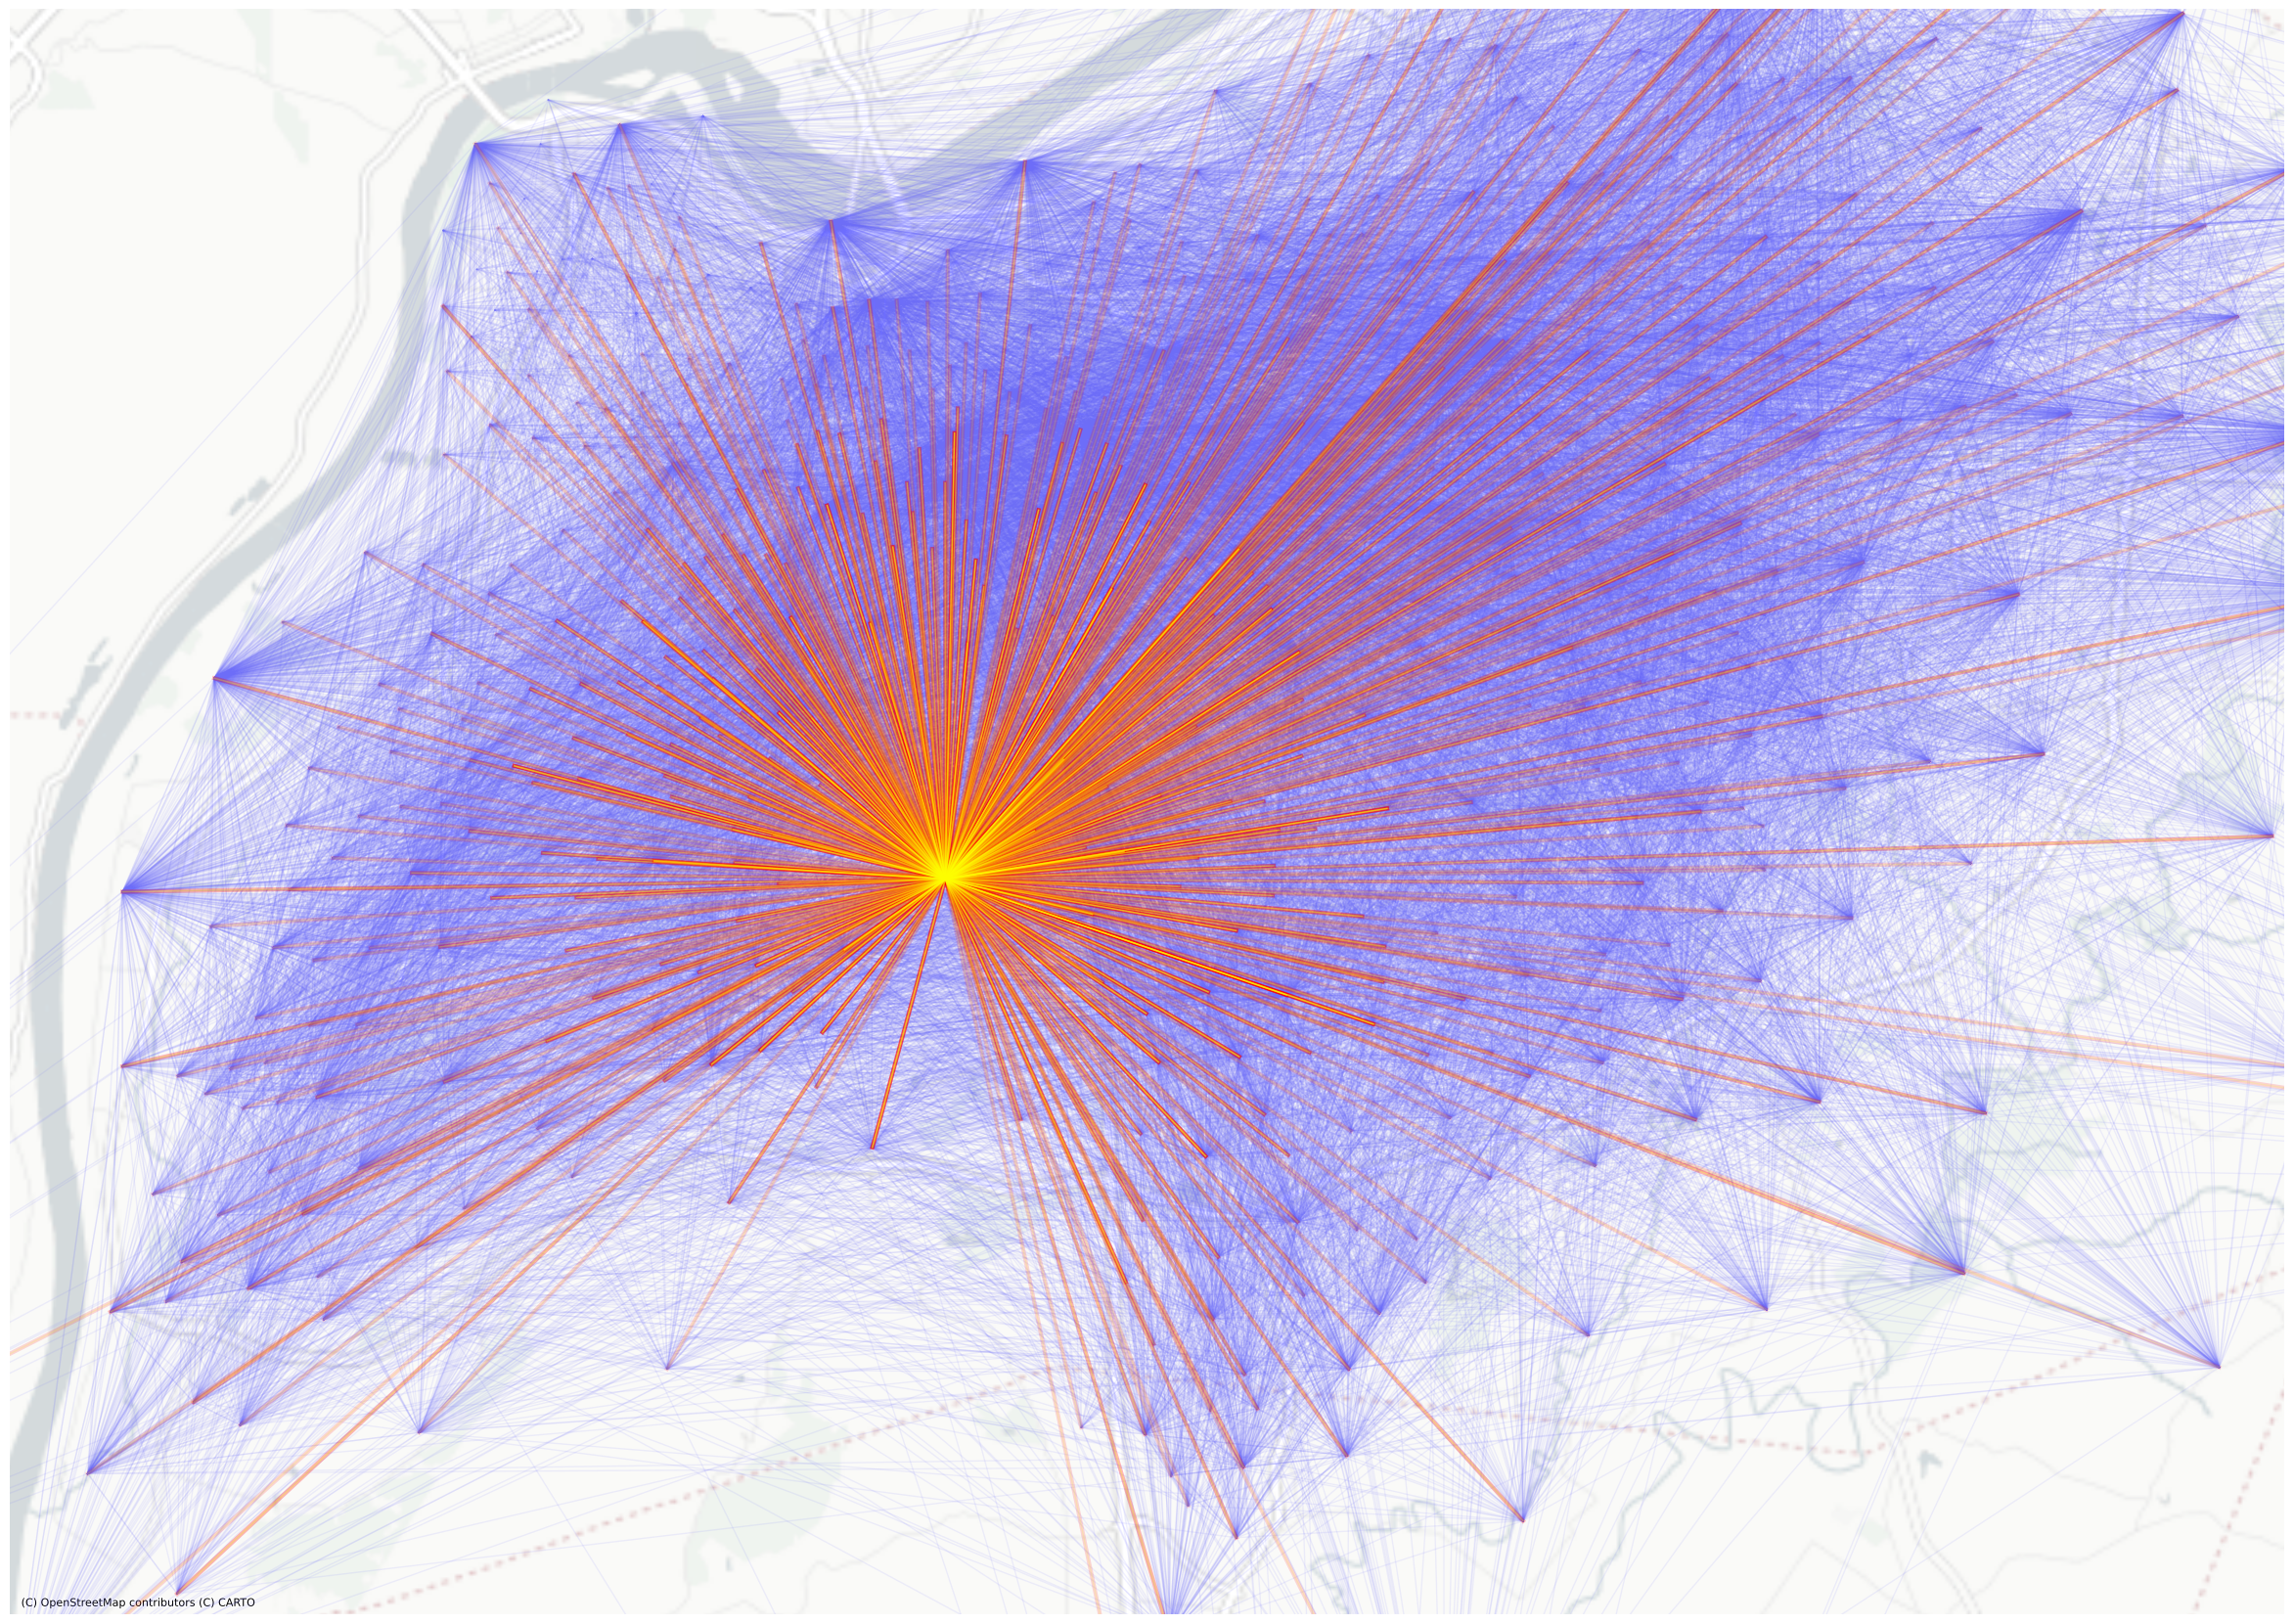

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import contextily as cx
from tqdm import tqdm
import random
import math

# Create the plot, set large figure size for details
fig, ax = plt.subplots(1, 1, figsize=(30, 30)) # Use subplots to get figure and axes
cbg_louisville_wm.plot(ax=ax, facecolor='none', edgecolor="none", legend=False)
ax.set_axis_off()

# Get cbg_louisville_wm bounds
bounds = cbg_louisville_wm.total_bounds  # returns [minx, miny, maxx, maxy]
minx, miny, maxx, maxy = bounds

# Print bounds for verification
print(f"数据边界范围: x范围 [{minx}, {maxx}], y范围 [{miny}, {maxy}]")

# Calculate cropped range
x_range = maxx - minx
y_range = maxy - miny

# Keep part of the area in x and y directions
x_start = minx + (x_range * 0.3)  # Crop 30% from the left
x_end = maxx - (x_range * 0.2)    # Crop 20% from the right
y_start = miny + (y_range * 0.4)  # Crop 40% from the bottom
y_end = maxy - (y_range * 0.2)    # Crop 20% from the top

# Set new x and y ranges
ax.set_xlim([x_start, x_end])
ax.set_ylim([y_start, y_end])

# Extract point coordinates
points = df_aea_centroids_wm.geometry
x_coords = points.x.reset_index(drop=True)
y_coords = points.y.reset_index(drop=True)

# --- Modification Starts Here ---

# List to store high-connection lines data: (i, j, length)
high_connection_lines_data = []
# List to store other lines data: (i, j)
other_lines_data = []

# First Pass: Identify lines to be drawn based on random sampling and connection type,
# and calculate lengths for high-connection lines to find the maximum.
print("Collecting line data and calculating lengths...")
for i in tqdm(range(len(matrix))):
    connected_points = [j for j in range(len(matrix[i])) if matrix[i][j] == 1]

    # Ensure num_to_connect does not exceed the number of available connected points
    # Original logic used max(1, int(...)), let's stick to that if connected_points is not empty
    num_to_connect1 = 0
    num_to_connect2 = 0
    if connected_points: # Only calculate if there are points to connect to
        num_to_connect1 = max(1, int(len(connected_points) * 1))
        num_to_connect2 = max(1, int(len(connected_points) * 1))

        if num_to_connect1 > len(connected_points):
            num_to_connect1 = len(connected_points)
        if num_to_connect2 > len(connected_points):
            num_to_connect2 = len(connected_points)
    else: # If no connected points, skip this iteration
        continue

    selected_points1 = random.sample(connected_points, num_to_connect1)
    selected_points2 = random.sample(connected_points, num_to_connect2)

    # Collect high-connection lines data from selected_points1
    for j in selected_points1:
        # Check if point i or point j is in high_connection_points
        if i in high_connection_points or j in high_connection_points:
            # Calculate length
            length = math.sqrt((x_coords[i] - x_coords[j])**2 + (y_coords[i] - y_coords[j])**2)
            high_connection_lines_data.append((i, j, length))

    # Collect other lines data from selected_points2
    for j in selected_points2:
        # Check if NEITHER point i NOR point j is in high_connection_points
        # And ensure this pair wasn't already captured as a high-connection line (less likely with sampling but good practice)
        if i not in high_connection_points and j not in high_connection_points:
             # Simple check to avoid adding duplicates if (j, i) was already added as (i, j) in other_lines,
             # or if the same (i,j) is somehow selected in selected_points2 multiple times.
             # Given the random sampling per i, duplicates within other_lines_data for a single i are unlikely.
             # Duplicates across i (e.g., line i-j and line j-i) are possible. We could add a check
             # like if (min(i, j), max(i, j)) not in {(min(x[0], x[1]), max(x[0], x[1])) for x in other_lines_data}
             # but for simplicity given the original code structure, we'll just append.
             other_lines_data.append((i, j))


# Find the maximum length among the identified high-connection lines
max_length_high_conn = 0
if high_connection_lines_data:
    max_length_high_conn = max(item[2] for item in high_connection_lines_data)

# Define thresholds based on max length
threshold_50_percent = max_length_high_conn * 0.50
threshold_20_percent = max_length_high_conn * 0.20

print(f"Maximum length among selected high-connection lines: {max_length_high_conn:.2f}")
print(f"Threshold (50%): {threshold_50_percent:.2f}")
print(f"Threshold (20%): {threshold_20_percent:.2f}")


# Second Pass: Draw the lines based on the length thresholds and type
print("Drawing lines with varying opacity...")

# Draw high-connection lines (yellow/red)
for i, j, length in tqdm(high_connection_lines_data):
    current_alpha = 0.4 # Default alpha for lines < 30% threshold

    # Apply opacity rules based on length relative to max
    if max_length_high_conn > 0: # Only apply rules if max length is meaningful
        if length > threshold_50_percent:
            current_alpha = 0.15
        elif length >= threshold_20_percent: # Implies length <= threshold_50_percent due to the 'if' above
            current_alpha = 0.15
        # Else: length < threshold_30_percent, current_alpha remains 0.4 (default)

    # Draw the red line
    ax.plot(
        [x_coords[i], x_coords[j]],
        [y_coords[i], y_coords[j]],
        color="#FF0000", # Red line
        linestyle="-",
        linewidth=3,
        alpha=current_alpha,
        zorder=9
    )
    # Draw the yellow line
    ax.plot(
        [x_coords[i], x_coords[j]],
        [y_coords[i], y_coords[j]],
        color="#FFFF00", # Yellow line
        linestyle="-",
        linewidth=1,
        alpha=current_alpha,
        zorder=10
    )

# Draw other lines (blue)
for i, j in tqdm(other_lines_data):
    ax.plot(
        [x_coords[i], x_coords[j]],
        [y_coords[i], y_coords[j]],
        color="#6D6DFF", # Blue line
        linestyle="-",
        linewidth=1,
        alpha=0.1, # Original alpha for blue lines
        zorder=5
    )

# Add basemap (make sure it matches the CRS after cropping)
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels)
# cx.add_basemap(ax, source=cx.providers.CartoDB.PositronOnlyLabels)

plt.savefig('fig1c-after.png', format='png', bbox_inches='tight', pad_inches=0)
plt.show()

In [43]:
import geopandas as gpd
import folium
from branca.colormap import linear
from branca.colormap import LinearColormap

non_zero_counts = []

# 遍历每一行
for row in matrix:
    # 统计该行中非零元素的数量
    count = sum(1 for x in row if x != 0)
    non_zero_counts.append(count)

# 假设您的 GeoDataFrame 变量名为 gdf
gdf = df_aea_centroids_wm  # 请确保这是正确的 GeoDataFrame 变量名
if len(non_zero_counts) != len(gdf):
    raise ValueError("列表长度必须与 GeoDataFrame 的行数一致！")

# non_zero_counts.sort(reverse=True)
print(non_zero_counts)
# 将列表添加到 GeoDataFrame 作为新列 'connection_num'
gdf['connection_num'] = non_zero_counts

# 1. 确保 x 列中的所有数值为正数
# 根据您的描述，x 列已经是正值（包括 0 和大于 0 的值），这里仅作检查和确保
gdf['x'] = gdf['x'].abs()  # 使用 abs() 确保所有值均为正数（虽然可能不需要）

# 2. 对 x 列应用对数变换
# 使用 np.log1p 来处理 x 值，避免 log(0) 的问题（log1p(x) = log(1 + x)）
gdf['x_log'] = np.log1p(gdf['x'])  # 创建一个新列 'x_log'，存储对数变换后的值

# 1. 检查并转换坐标系到 WGS84（EPSG:4326）
# Folium 需要经纬度坐标（WGS84），而您的 geometry 列可能是投影坐标系
if gdf.crs is None:
    # 如果 CRS 未定义，假设原始坐标系为 Web Mercator (EPSG:3857)
    gdf.set_crs('EPSG:3857', inplace=True)
if gdf.crs != 'EPSG:4326':
    gdf = gdf.to_crs('EPSG:4326')

# 2. 从 geometry 列提取经纬度
gdf['longitude'] = gdf['geometry'].x  # 提取经度
gdf['latitude'] = gdf['geometry'].y   # 提取纬度

# 3. 创建 Folium 地图
# 使用所有点的经纬度平均值作为地图中心
map_center = [gdf['latitude'].mean(), gdf['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=10)

# 4. 根据 x 列数值创建颜色映射
x_values = gdf['connection_num']
colormap = LinearColormap(
    colors=['#00008B', '#FF0000'],  # 深蓝色 (#00008B) 到深红色 (#FF0000)
    vmin=x_values.min(),
    vmax=x_values.max()
)
high_connection_points = {}
# 5. 为每个点添加实心圆（CircleMarker）
for idx, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],  # 点的位置
        radius=5,                                      # 圆的半径，可调整
        color='black',                                 # 边框颜色
        fill=True,                                     # 填充实心圆
        fill_color=colormap(row['connection_num']),                 # 根据 x 值设置填充颜色
        fill_opacity=0.7,                              # 填充透明度
        popup=f"connection_num: {row['connection_num']}"                         # 点击圆时显示 x 值
    ).add_to(m)

    if row['connection_num'] == 494:
        high_connection_points[idx] = {
            'latitude': row['latitude'],
            'longitude': row['longitude'],
            'connection_num': row['connection_num']
        }

print(high_connection_points)
# 6. 添加颜色条到地图
colormap.caption = 'X 值颜色条'  # 颜色条标题
colormap.add_to(m)

# 7. 保存地图为 HTML 文件
display(m)
# m.save('map_visualization.html')

# print("地图已生成并保存为 'map_visualization.html'，请在浏览器中打开查看。")

[5, 2, 0, 7, 127, 19, 13, 0, 18, 35, 80, 72, 165, 200, 156, 21, 87, 1, 3, 0, 0, 14, 1, 5, 4, 0, 27, 130, 24, 13, 81, 43, 39, 48, 9, 13, 0, 0, 0, 0, 202, 1, 118, 169, 35, 12, 2, 0, 4, 0, 0, 0, 143, 13, 39, 6, 19, 8, 77, 0, 6, 2, 111, 51, 55, 10, 5, 22, 9, 10, 23, 0, 34, 3, 43, 1, 39, 0, 2, 40, 28, 318, 138, 0, 375, 34, 1, 1, 2, 355, 15, 14, 14, 0, 3, 10, 34, 1, 50, 135, 10, 2, 20, 16, 90, 0, 1, 1, 8, 27, 9, 11, 0, 8, 0, 5, 0, 0, 54, 13, 28, 34, 47, 15, 0, 2, 64, 0, 1, 3, 9, 33, 2, 0, 45, 20, 1, 0, 6, 56, 0, 0, 31, 6, 21, 168, 15, 23, 0, 138, 56, 8, 155, 0, 4, 9, 1, 7, 16, 23, 20, 8, 14, 73, 10, 1, 1, 38, 40, 2, 2, 14, 0, 8, 32, 177, 8, 30, 3, 34, 58, 7, 0, 12, 494, 299, 49, 292, 8, 26, 22, 0, 95, 48, 101, 65, 0, 1, 6, 6, 14, 166, 20, 291, 98, 108, 2, 27, 21, 0, 20, 10, 17, 200, 180, 16, 5, 488, 28, 0, 18, 34, 75, 3, 11, 3, 3, 328, 70, 31, 4, 0, 11, 4, 11, 0, 3, 18, 6, 365, 2, 0, 58, 38, 3, 6, 22, 2, 2, 18, 11, 13, 3, 227, 48, 455, 350, 30, 0, 104, 102, 1, 22, 28, 127, 28, 0, 3, 38, 95, 